In [11]:
import requests
from bs4 import BeautifulSoup
import os
from tqdm.notebook import tqdm
import pandas as pd
from loguru import logger
import time
import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

# from db_connector import DB_Connector
from plotter import DataFramePlotter







def get_html_from_url(url):


    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

    # Send HTTP request to site and save the response from server in a response object called r
    r = requests.get(url, headers=headers)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(r.text, 'html.parser')

    # Extract the desired info (the offers in this case)
    # The selector depends on the structure of the webpage, inspect the webpage to find the right selector
    offers = soup.select('div.offer')

    while True:
        response = requests.get(url)

        if response.status_code == 429:  # HTTP 429 means Too Many Requests / 500 server error
            print("Hit rate limit, sleeping for a bit...")
            time.sleep(5)  # Wait for 10 seconds before trying again
            continue


        if response.status_code != 200:
            print("Encountered Server Error, sleeping for a bit longer...")
            time.sleep(240)  # Wait for 10 seconds before trying again
            continue

        # If the response was not a 429, break the loop
        break

    # You might also want to check here if the response was a 200 OK
    # If not, you could raise an exception or return some default value
    if response.status_code != 200:
        print(f"Got unexpected status code {response.status_code}")
        return None

    # Add a delay between 1 and 3 seconds before next request
    # time.sleep(random.uniform(1, 3))

    return response.text


def find_all(string, substring):
    start = 0
    while True:
        start = string.find(substring, start)
        if start == -1: return
        end = start + 100
        yield string[start:end]
        start += len(substring) # use start += 1 to find overlapping matches


def get_cat_overview(url):


    page = get_html_from_url(url)

    substring_damen, substring_herren = "/damen", "/herren"


    cat_urls_uncut_damen = set(find_all(page, substring_damen))
    cat_urls_uncut_herren = set(find_all(page, substring_herren))



    cat_urls_cut_damen, cat_urls_cut_herren, cat_names_damen, cat_names_herren = [],[],[],[]


    for i in cat_urls_uncut_damen:
        i = i.split(sep='\"')
        cat_urls_cut_damen.append("https://www.vinted.de{}".format(i[0]))
        cat_names_damen.append(i[0])
        # print(i)

    for i in cat_urls_uncut_herren:
        i = i.split(sep='\"')
        cat_urls_cut_herren.append("https://www.vinted.de{}".format(i[0]))
        cat_names_herren.append(i[0])

    print("We found {} categories for women on vinted that we can scrape".format(len(cat_urls_uncut_damen)))
    print("We found {} categories for men vinted that we can scrape".format(len(cat_urls_uncut_herren)))
    # for name in cat_names_damen:
    #     print(name)
    return cat_urls_cut_damen, cat_urls_cut_herren, cat_names_damen, cat_names_herren
    


def filter_doubles(titles_cut):
    doubles = []
    for i in titles_cut:
        c = titles_cut.count(i)

            # print("Title: {} occured {} times.".format(i,c))
        doubles.append((i,c))

    set_d = set(doubles)
    # for i in set_d:
        # print(i)
    names = list(set_d)
    return names

def get_display_titles(cat_urls_cut,cat_names):

    c = 0
    display_titles = []
    pbar = tqdm(total=len(cat_urls_cut))
    for url, name in zip(cat_urls_cut,cat_names):
        # Send HTTP request to site and save the response from server in a response object called r
        r = requests.get(url)
        c += 1
        # print(c)
        
        # Get the index of display title 
        index_title = r.text.find("<title>")
        title_uncut = r.text[index_title:index_title+100]
        splt = title_uncut.split(sep=" |")
        display_titles.append(splt[0])

        # Create a BeautifulSoup object and specify the parser      
        soup = BeautifulSoup(r.text, 'html.parser')
        filename = "%s.txt" % name[1:]
        filename = filename.replace("/","_")
        pbar.update()

    pbar.close()
    titles_cut = []
    for title in display_titles:
        title = title[7:]
        title = title.replace("&amp;","\\u0026")
        titles_cut.append(title)
    return titles_cut

def get_display_titles_wrapper(cat_names_damen,cat_names_herren, cat_urls_cut_damen, cat_urls_cut_herren):
    sub_path = path + '/categories'
    if not os.path.exists(sub_path):
        os.makedirs(sub_path)
    # print(sub_path)

    display_titles_damen = get_display_titles(cat_urls_cut_damen,cat_names_damen)
    display_titles_herren = get_display_titles(cat_urls_cut_herren,cat_names_herren)

    
    titles_cut_with_count_damen = filter_doubles(display_titles_damen)
    titles_cut_with_count_herren = filter_doubles(display_titles_herren)

    return titles_cut_with_count_damen, titles_cut_with_count_herren



def get_single_property(str:str,p:str):
    i = str.find(p)
    sub = str[i:]
    sub = sub.split(",")
    sub = sub[0]
    prop_len = len(p)
    name = sub[:prop_len]
    sub = sub[prop_len+1:]
    return name, sub




def get_dataframe(url, names, properties):

    index_page = get_html_from_url(url)

    for i in names:
        start = 0
        for j in range(i[1]):
            
            list_name = []
            dict_props = {}
            ind = index_page.find(i[0], start)
            
            # Get rough length to be cut 
            sub = index_page[ind-20:ind+1000]
            
            # Assign the new start for str.find() as to not retrieve the same index 2x
            start = ind + len(sub)


            sub = sub.replace("{","")
            sub = sub.replace("\"","")

            # Obtain all single desired properties of substring
            for p in properties:
                name, value = get_single_property(sub, p)
                dict_props[p] = value


            # convert the dictionary to a pandas DataFrame
            df = pd.DataFrame(dict_props, index=[0])
            yield df


def get_dataframe_category(html,subs, props):

    for i in subs:
        dict_props = {}
        ind = html.find(i)
        
        # Get rough length to be cut 
        sub = html[ind:ind+5000]
        splt = sub.split("\",\"content_source\"")
        sub = splt[0]    


        sub = sub.replace("{","")
        sub = sub.replace("\"","")

        # Obtain all single desired properties of substring
        for p in props:
            name, value = get_single_property(sub, p)
            dict_props[p] = value


        # convert the dictionary to a pandas DataFrame
        df = pd.DataFrame(dict_props, index=[0])
        # print(df.head())

        yield df


def get_announces_by_category(category_id, nr_pages, props):

    properties_announce = ['id','title','price','brand_title','size_title','user:id','login','profile_url'] 

    for page in tqdm(range(nr_pages), leave=False):
        try:
                
            url = "https://www.vinted.de/catalog?catalog[]={}&page{}".format(category_id,page+1)
            # print(url)
            html_string = get_html_from_url(url)
            # print(html_string)

            l = list(get_items_ids(html_string))
            unique_id_references = ["\"id\":"+i for i in l]
            # print(unique_id_references)

            announces = list(get_dataframe_category(html=html_string, subs=unique_id_references, props= props))

            announces_df = pd.concat(announces)
            # print(announces_df.head())
            # time.sleep(2)
            yield announces_df
            
        except Exception as e:
            # logger.exception(e)
            logger.error("Error getting Category Information".format(e))

def get_items_ids(page):
    length = 1500
    s = "{\"catalogItems\":{\"ids\":"
    index = page.find(s)
    sub = page[index:index+length]

    # Remove everything around the ids
    splts = sub.split("[")
    sub = splts[1]
    splts = sub.split("]")
    sub = splts[0]
    
    splt = sub.split(",")
    for i in splt:
        yield i


def save_to_Database(db,df):    
    print("Function called", flush=True)
    today = date.today()
    docs = None
    docs = db.retrieve_data(today)
    if docs != None:
        print(docs,flush=True)
    else:
        print("Returned nothing form db", flush=True)








In [68]:

class DataFramePlotter:
    def __init__(self, df):
        self.df = df
        print('Launched Dataframe-Plotter')
        self.folder_name = "images/" + date.today().strftime("%Y/%m/%d") + '/'
        if not os.path.exists(self.folder_name):
            os.makedirs(self.folder_name)
        # os.mkdir('images')
        

    # def plot_and_save(self, x, y, filename):
    #     sns_plot = sns.scatterplot(data=self.df, x=x, y=y)
    #     fig = sns_plot.get_figure()
    #     fig.savefig(filename)
    #     plt.clf()  # clear the figure


    def plot_amount_categories_MW(self):
        image_name = self.folder_name + 'amounts_category_MW.jpg'
        x = ['women', 'men']
        df = self.df[self.df['overview'] == 1]
        print(len(df))

        count_m = df['gender'].value_counts().get('m')
        count_w = df['gender'].value_counts().get('w')
        y = [count_w, count_m]
        ax = sns.barplot(x=x, y=y, linewidth=0.5)
        fig = ax.get_figure()
        fig.savefig(image_name)
        # plt.clf()

    def plot_amount_announces_per_category(self):
        image_name = self.folder_name + 'amounts_per_category.jpg'

        df = self.df[self.df['overview'] == 1]
        df = df[df['title'] != '']
        df = df[df['item_count'] != '']
        df['item_count'] = df['item_count'].astype(int)
        df_sorted = df.sort_values('item_count', ascending=False)
        fig, ax = plt.subplots(figsize=(40, 20))
        sns.barplot(data=df_sorted, x='title',y='item_count', ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), size=8)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        for item in ax.get_xticklabels():
            item.set_rotation(90)
        plt.subplots_adjust(bottom=0.3)
        fig = ax.get_figure()
        
        fig.savefig(image_name)


    def plot_average_price_per_category(self):

        image_name = self.folder_name + 'average_price_per_category.jpg'

        df = self.df[self.df['overview'] == 0].copy()

        df['price'] = pd.to_numeric(df['price'], errors='coerce')
        df = df.dropna(subset=['price'])
        df['price'] = df['price'].astype(np.float32)


        df['price'] = df['price'].astype(str)
        df['price'] = df['price'].str.replace('[^0-9.]', '', regex=True)
        df['price'] = df['price'].astype(float)
        df = df.groupby('cat_title')['price'].mean().reset_index()

        df['price'] = df['price'].astype(int)
        df_sorted = df.sort_values('price', ascending=False)

        fig, ax = plt.subplots(figsize=(40, 20))
        sns.barplot(data=df_sorted, x='cat_title',y='price', ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), size=8)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        for item in ax.get_xticklabels():
            item.set_rotation(90)
        plt.subplots_adjust(bottom=0.3)
        fig = ax.get_figure()
        fig.savefig(image_name)


    def plot_announces_per_user(self):

        image_name = self.folder_name + 'announces_per_user_top200.jpg'

        df = self.df[self.df['overview'] == 0].copy()
        df = df['login'].value_counts().sort_values(ascending=False)

        logger.debug(df.shape[0])
        # Split data into three groups
        first_200 = df[:200].reset_index()
        # next_200 = df[200:400].reset_index()
        # rest = df[400:].reset_index()
        # print(first_200)

        # Plot the first 200
        fig, ax = plt.subplots(figsize=(40,20))
        sns.barplot(data=first_200, x='index', y='login')
        plt.title('Top 200 Users')
        plt.xlabel('Users')
        plt.ylabel('Counts')
        plt.xticks(rotation=90)
        plt.show()
        plt.subplots_adjust(bottom=0.3)
        fig = ax.get_figure()
        fig.savefig(image_name)

        # # Plot the next 200
        # plt.figure(figsize=(40,20))
        # sns.barplot(data=next_200, x='index', y='login')
        # plt.title('Next 200 Users')
        # plt.xlabel('Users')
        # plt.ylabel('Counts')
        # plt.xticks(rotation=90)
        # plt.show()

        # # Plot the rest
        # plt.figure(figsize=(40,20))
        # sns.barplot(data=rest, x='index', y='login')
        # plt.title('Remaining Users')
        # plt.xlabel('Users')
        # plt.ylabel('Counts')
        # plt.xticks(rotation=90)
        # plt.show()

In [3]:
# # Get MongoDB username, password, and hostname from environment variables
# # username = os.environ['MONGO_USERNAME']
# # password = os.environ['MONGO_PASSWORD']
# # hostname = os.environ['MONGO_HOSTNAME']

# # db = DB_Connector(username=username,password=password,hostname=hostname)

path = os.getcwd()


# Define the URL of the site
url = f"https://www.vinted.de/"
properties = ['id','title','code','item_count','url']
properties_announce = ['id','title','price','brand_title','size_title','user:id','login','profile_url'] 

# Get CatNames
cat_urls_cut_damen, cat_urls_cut_herren, cat_names_damen, cat_names_herren = get_cat_overview(url)

display_titles_women, display_titles_men = get_display_titles_wrapper(cat_names_damen,cat_names_herren,cat_urls_cut_damen, cat_urls_cut_herren)


dfs_women = list(get_dataframe(url, display_titles_women,properties))
dfs_men = list(get_dataframe(url, display_titles_men,properties))
combined_women = pd.concat(dfs_women)
combined_men = pd.concat(dfs_men)

combined_women['gender'] = 'w'
combined_men['gender'] = 'm'

df = pd.concat([combined_women, combined_men])

df = df[df['id'] != 'null']
df['overview'] = 1
df['title'] = df['title'].str.replace('\\u0026', '&')
print(df.head())
# Check that there is no duplicates in list and have a look into the df

# db.save_data(df)


# ==================================================
# ========= Get announces by category ==============
# ==================================================






We found 283 categories for women on vinted that we can scrape
We found 190 categories for men vinted that we can scrape


  0%|          | 0/283 [00:00<?, ?it/s]

  0%|          | 0/190 [00:00<?, ?it/s]

     id                 title                     code item_count  \
0  1183  Mäntel \u0026 Jacken  MATERNITY_COATS_JACKETS      19984   
0  2630           Sportschuhe        WOMEN_SPORT_SHOES     706431   
0    26         Sonnenbrillen               SUNGLASSES     629616   
0   166           Schmucksets         WOM_ACC_JEW_SETS     405635   
0  2632               Sneaker           WOMEN_TRAINERS    2978596   

                                                 url gender  overview  
0  /damen/kleidung/umstandskleidung/mantel-and-ja...      w         1  
0                                                         w         1  
0                   /damen/accessoires/sonnenbrillen      w         1  
0             /damen/accessoires/schmuck/schmucksets      w         1  
0                              /damen/schuhe/sneaker      w         1  
['1183', '2630', '26', '166', '2632', '967', '229', '1125', '1846', '13', '962', '573', '2648', '1030', '1446', '120', '541', '213', '1442', '2645', '146

/var/folders/zs/bd_b6ytj5l916s0yf_qyvlp80000gq/T/ipykernel_97208/2315804948.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title'] = df['title'].str.replace('\\u0026', '&')


In [9]:
import numpy as np
# Assuming df is your DataFrame and 'col_name' is your column
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df = df.dropna(subset=['id'])
df['id'] = df['id'].astype(np.int64)


cat_ids = df['id'].values.tolist()
cat_titles = df['title'].values.tolist()

# cat_ids = cat_ids[cat_idss['id'].notna()]
# cat_ids = cat_ids[:10]
print(cat_ids)

[1183, 2630, 26, 166, 2632, 967, 229, 1125, 1846, 13, 962, 573, 2648, 1030, 1446, 120, 541, 213, 1442, 2645, 146, 534, 11, 1061, 152, 2528, 1093, 1843, 958, 1181, 192, 1097, 123, 163, 227, 1078, 237, 158, 191, 958, 29, 197, 176, 201, 228, 1864, 189, 205, 220, 124, 580, 18, 155, 240, 235, 153, 1443, 88, 1087, 28, 2524, 1874, 14, 1041, 232, 1851, 1037, 538, 2527, 196, 577, 1184, 179, 1617, 548, 1834, 12, 2637, 2529, 1076, 1840, 2622, 88, 1090, 2655, 1126, 2688, 1263, 1781, 1442, 1842, 8, 89, 1841, 1778, 1070, 2651, 233, 1140, 1903, 2689, 223, 187, 543, 9, 218, 21, 539, 1066, 1058, 219, 1837, 2642, 1493, 1134, 964, 1850, 1264, 1185, 529, 542, 157, 1065, 1042, 1099, 1906, 2640, 215, 1849, 203, 1440, 2624, 1845, 540, 1616, 2650, 1037, 1441, 211, 1101, 156, 167, 1784, 160, 2530, 1086, 2618, 1773, 15, 1099, 1125, 572, 185, 8, 1129, 73, 204, 2636, 553, 2653, 1035, 2687, 1055, 2525, 1774, 2635, 2643, 194, 552, 1186, 1777, 1848, 1779, 236, 1103, 2639, 2644, 2641, 1615, 1100, 1221, 2532, 2531, 20

In [ ]:
pbar = tqdm(total=len(cat_ids))
for i, j in zip(cat_ids, cat_titles):
    try:
        announces = list(get_announces_by_category(i, 5, properties_announce))
        df_cat = pd.concat(announces)
        df_cat['cat_id'] = i
        df_cat['cat_title'] = j
        df_cat['overview'] = 0
        # db.save_data(df_cat)
        df =  pd.concat([df, df_cat])
        pbar.update()
    except Exception as e:
        print(e)
pbar.close()
# test_df = db.retrieve_data(date=date.today())
# df = pd.DataFrame(test_df)
# df.to_csv('mydf.csv',index=False)
print(df)
print(type(df))
print(df.shape[0])


In [42]:
df['title'] = df['title'].str.replace('\\u0026', '&')

/var/folders/zs/bd_b6ytj5l916s0yf_qyvlp80000gq/T/ipykernel_97208/403444456.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title'] = df['title'].str.replace('\\u0026', '&')


Launched Dataframe-Plotter
433


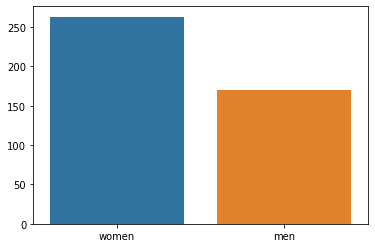

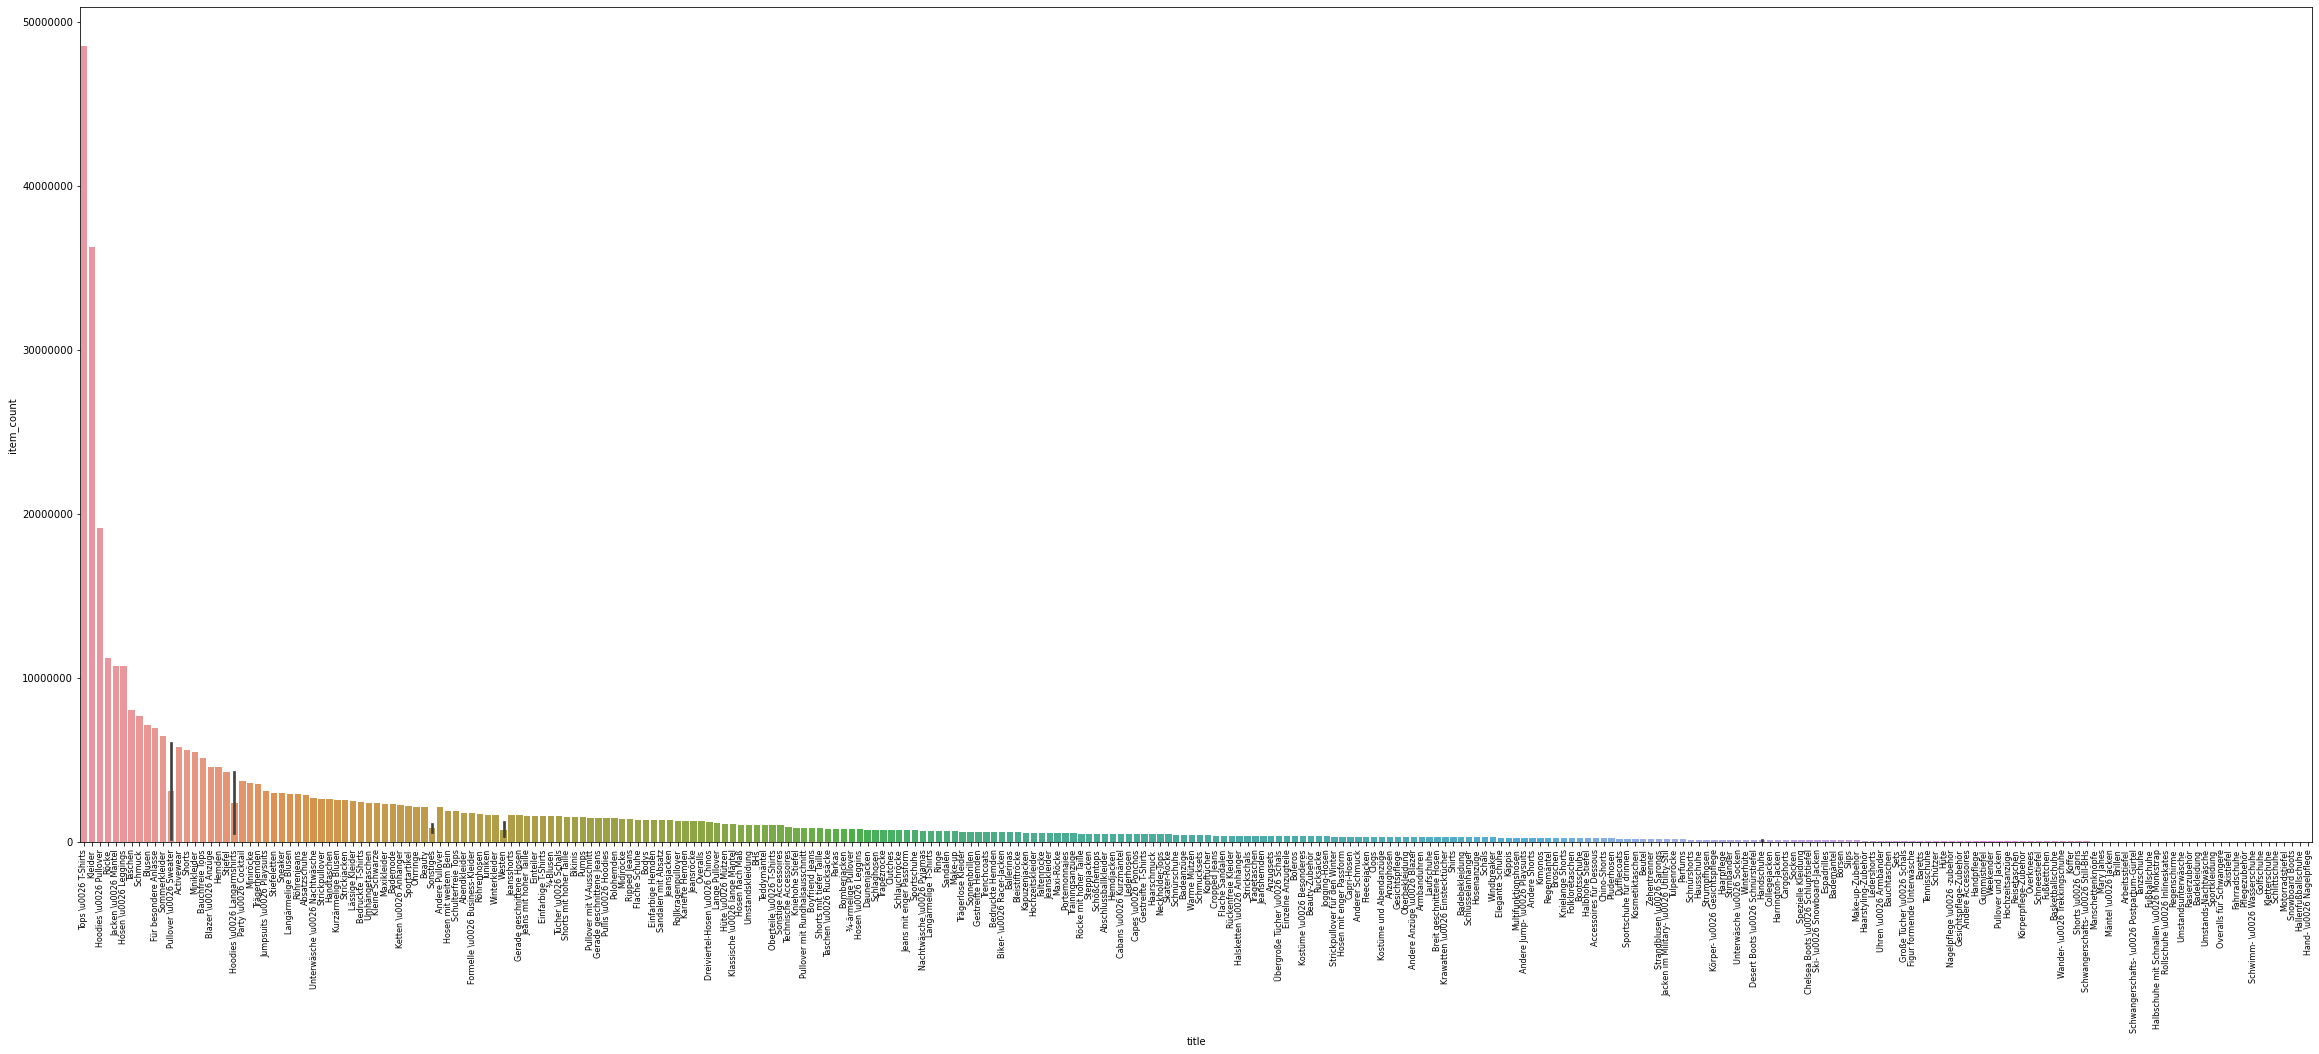

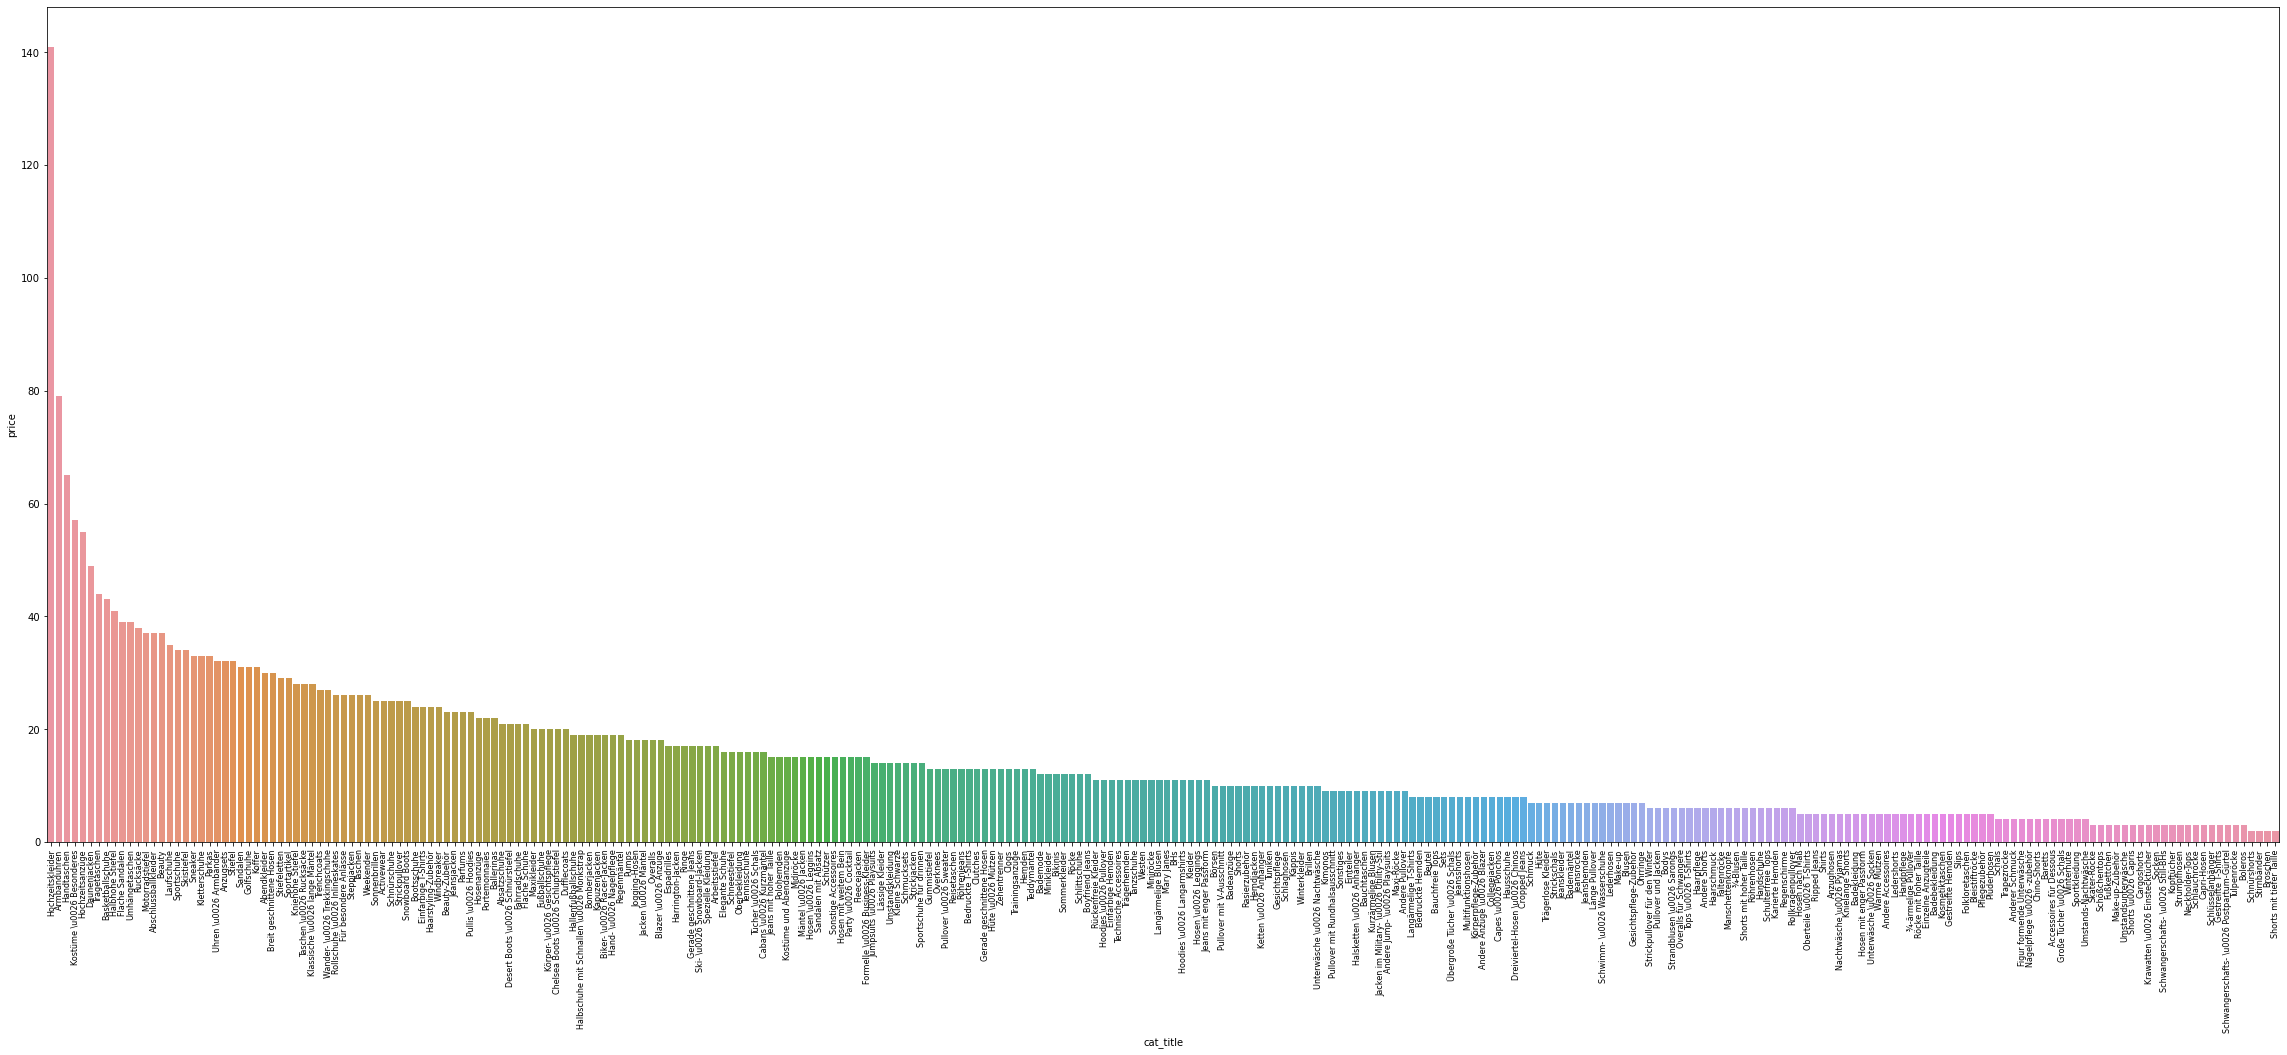

In [69]:
plotter = DataFramePlotter(df)
plotter.plot_amount_categories_MW()
plotter.plot_amount_announces_per_category()
plotter.plot_average_price_per_category()

2023-08-02 20:29:38.264 | DEBUG    | __main__:plot_announces_per_user:89 - 23355


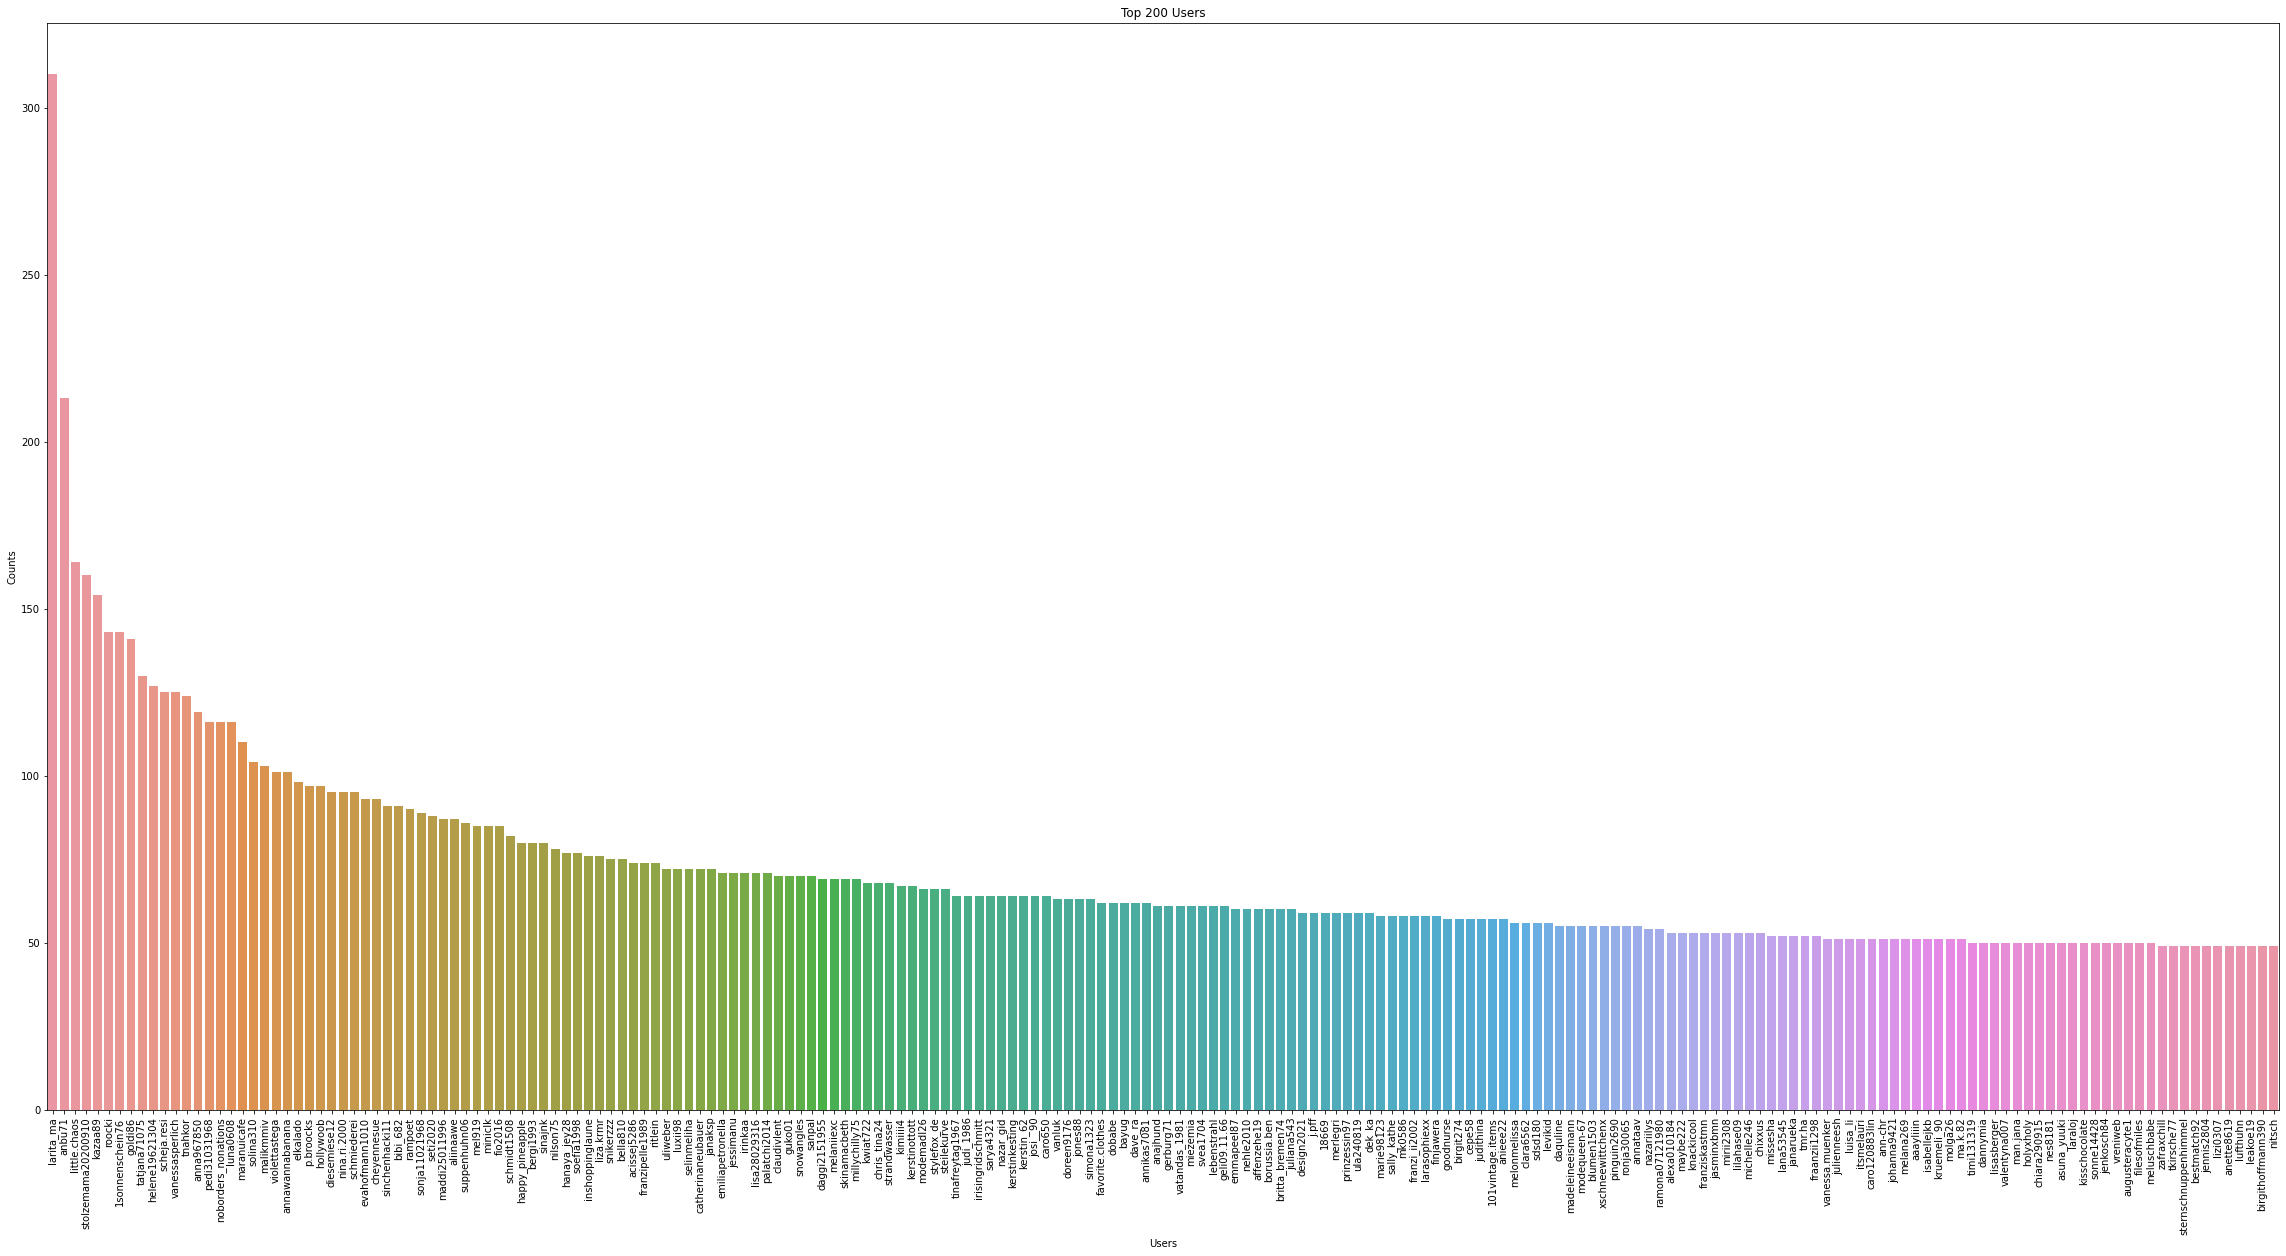

<Figure size 432x288 with 0 Axes>

In [70]:
plotter.plot_announces_per_user()